<a href="https://colab.research.google.com/github/punch-boxing/punch-ml/blob/main/punch_ml_pytorch_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Settings

In [ ]:
# default values
PUNCH_TYPES = {
    "None": 0,
    "Straight": 1,
    "Hook": 2,
    "Body": 3,
    "Uppercut": 4,
}

# values for model training
INPUT_SIZE = 3
HIDDEN_SIZE = 10
NUM_LAYERS = 1
WINDOW_SIZE = 20


# values for preparing data
MAX_DATA_NUMBER = 20 # file counts
ACCELERATION_DATA_TYPE = "Raw Acceleration" # "Acceleration" for "Raw Acceleration"

# 1. Preparing Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PunchGRUModel(nn.Module):
  def __init__(self, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, num_classes=len(PUNCH_TYPES)):
    super(PunchGRUModel, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.input_size = input_size

    # a layer that puts the accelerometer value into tanh function, this layer makes the accelerometer value from -1 ~ 1
    self.tanh = nn.Tanh()
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x, h=None):
    # x: (batch, seq_len, input_size)
    if self.input_size == 3:
      x = self.tanh(x)
    elif self.input_size == 5:
      x[:3] = self.tanh(x[:3])
    else:
      raise ValueError("input_size must be 3 or 5")
    out, h = self.gru(x, h)
    logits = self.fc(out)
    return logits, h


# 2. Preparing Data

In [ ]:
import pandas as pd

raw_datas = []

# Columns
# Index,Time,Raw Acceleration X,Raw Acceleration Y,Raw Acceleration Z,Acceleration X,Acceleration Y,Acceleration Z,Angular Velocity X,Angular Velocity Y,Angular Velocity Z,Orientation X,Orientation Y,Orientation Z,Punch Type

for i in range(1, MAX_DATA_NUMBER + 1):
  try:
    data = pd.read_csv(f"{i}.csv")
    data["Punch Index"] = data["Punch Type"].map(PUNCH_TYPES).fillna(0).astype(int)
    raw_datas.append(data)
  except:
    print(f"No data for {i}.csv")

No data for 15.csv
No data for 16.csv
No data for 17.csv
No data for 18.csv
No data for 19.csv
No data for 20.csv


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

if INPUT_SIZE == 3:
  datas = []
  targets = []

  for data in raw_datas:
    x = data[ACCELERATION_DATA_TYPE + " X"].values
    y = data[ACCELERATION_DATA_TYPE + " Y"].values
    z = data[ACCELERATION_DATA_TYPE + " Z"].values
    punch = data['Punch Index'].values

    for i in range(WINDOW_SIZE, len(data) + 1):
      datas.append(np.array([
          x[i-WINDOW_SIZE:i],
          y[i-WINDOW_SIZE:i],
          z[i-WINDOW_SIZE:i],
      ]).T)
      targets.append(punch[i-WINDOW_SIZE:i])

  X = np.array(datas, dtype=np.float32)
  y = np.array(targets)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  train_loader = torch.utils.data.DataLoader(
      torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
      batch_size=64,
      shuffle=True
  )

  test_loader = torch.utils.data.DataLoader(
      torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)),
      batch_size=64,
      shuffle=False
  )

  for data, target in train_loader:
    print(data.shape, target.shape)
    break

elif INPUT_SIZE == 5:
  datas = []
  targets = []

  for data in raw_datas:
    x = data[ACCELERATION_DATA_TYPE + " X"].values
    y = data[ACCELERATION_DATA_TYPE + " Y"].values
    z = data[ACCELERATION_DATA_TYPE + " Z"].values
    ox = data["Orientation X"].values
    oz = data["Orientation Z"].values
    punch = data['Punch Index'].values

    for i in range(WINDOW_SIZE, len(data) + 1):
      datas.append(np.array([
          x[i-WINDOW_SIZE:i],
          y[i-WINDOW_SIZE:i],
          z[i-WINDOW_SIZE:i],
          ox[i-WINDOW_SIZE:i],
          oz[i-WINDOW_SIZE:i],
      ]).T)
      targets.append(punch[i-WINDOW_SIZE:i])

  X = np.array(datas, dtype=np.float32)
  y = np.array(targets)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  train_loader = torch.utils.data.DataLoader(
      torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
      batch_size=64,
      shuffle=True
  )

  test_loader = torch.utils.data.DataLoader(
      torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)),
      batch_size=64,
      shuffle=False
  )

  for data, target in train_loader:
    print(data.shape, target.shape)
    break

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([64, 20, 3]) torch.Size([64, 20])
(8850, 20, 3) (8850, 20)
(2213, 20, 3) (2213, 20)


# 3. Compiling Model

In [ ]:
def summary_custom(model):
    print(f"{'Layer':<40} {'Shape':<30} {'Param #':>10}")
    print("=" * 82)

    total_params = 0
    trainable_params = 0

    for name, param in model.named_parameters():
        param_shape = tuple(param.shape)
        param_count = param.numel()
        total_params += param_count
        if param.requires_grad:
            trainable_params += param_count

        print(f"{name:<40} {str(param_shape):<30} {param_count:>10}")

    print("=" * 82)
    print(f"{'Total params:':<40} {total_params:>30}")
    print(f"{'Trainable params:':<40} {trainable_params:>30}")
    print(f"{'Non-trainable params:':<40} {total_params - trainable_params:>30}")

print(f"Using Device : {device}")

# model = PUNCH_ML().to(device)
model = PunchGRUModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

summary_custom(model)


Using Device : cpu
Layer                                    Shape                             Param #
gru.weight_ih_l0                         (30, 3)                                90
gru.weight_hh_l0                         (30, 10)                              300
gru.bias_ih_l0                           (30,)                                  30
gru.bias_hh_l0                           (30,)                                  30
fc.weight                                (5, 10)                                50
fc.bias                                  (5,)                                    5
Total params:                                                       505
Trainable params:                                                   505
Non-trainable params:                                                 0


# 4. Training Model

In [ ]:
best_loss = float('inf')
epochs = 500
patience = 5
counter = 0

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
    model.train()

    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    for data, target in train_loader:
        data = data.to(device, dtype=torch.float32)
        target = target.to(device)

        optimizer.zero_grad()
        outputs, _ = model(data)

        # reshaping results
        outputs = outputs.view(-1, outputs.size(-1))
        target = target.view(-1)

        # update parameters
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == target).sum().item()
        total_train_samples += target.size(0)

    train_loss.append(total_train_loss / len(train_loader))
    train_accuracy.append(total_train_correct / total_train_samples)

    total_val_loss = 0.0
    total_val_correct = 0
    total_val_samples = 0




    model.eval()
    for data, target in test_loader:
        data = data.to(device, dtype=torch.float32)
        target = target.to(device)

        outputs, _ = model(data)
        outputs = outputs.view(-1, outputs.size(-1))
        target = target.view(-1)

        loss = criterion(outputs, target)

        total_val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_val_correct += (predicted == target).sum().item()
        total_val_samples += target.size(0)

    val_loss.append(total_val_loss / len(test_loader))
    val_accuracy.append(total_val_correct / total_val_samples)


    if total_val_loss < best_loss:
        best_loss = total_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

    print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {train_loss[-1]:.4f} | Train Accuracy: {train_accuracy[-1]*100:.2f}% | Validation Loss: {val_loss[-1]:.4f} | Validataion Accuracy: {val_accuracy[-1]*100:.2f}%")


Epoch   1/500 | Train Loss: 1.0404 | Train Accuracy: 72.99% | Validation Loss: 0.3422 | Validataion Accuracy: 96.36%
Epoch   2/500 | Train Loss: 0.2680 | Train Accuracy: 96.45% | Validation Loss: 0.2353 | Validataion Accuracy: 96.48%
Epoch   3/500 | Train Loss: 0.2216 | Train Accuracy: 96.50% | Validation Loss: 0.2118 | Validataion Accuracy: 96.48%
Epoch   4/500 | Train Loss: 0.2017 | Train Accuracy: 96.48% | Validation Loss: 0.1918 | Validataion Accuracy: 96.45%
Epoch   5/500 | Train Loss: 0.1812 | Train Accuracy: 96.43% | Validation Loss: 0.1722 | Validataion Accuracy: 96.44%
Epoch   6/500 | Train Loss: 0.1656 | Train Accuracy: 96.44% | Validation Loss: 0.1592 | Validataion Accuracy: 96.45%
Epoch   7/500 | Train Loss: 0.1547 | Train Accuracy: 96.45% | Validation Loss: 0.1504 | Validataion Accuracy: 96.45%
Epoch   8/500 | Train Loss: 0.1473 | Train Accuracy: 96.46% | Validation Loss: 0.1437 | Validataion Accuracy: 96.45%
Epoch   9/500 | Train Loss: 0.1412 | Train Accuracy: 96.47% | Va

# 5. Evaluating Model

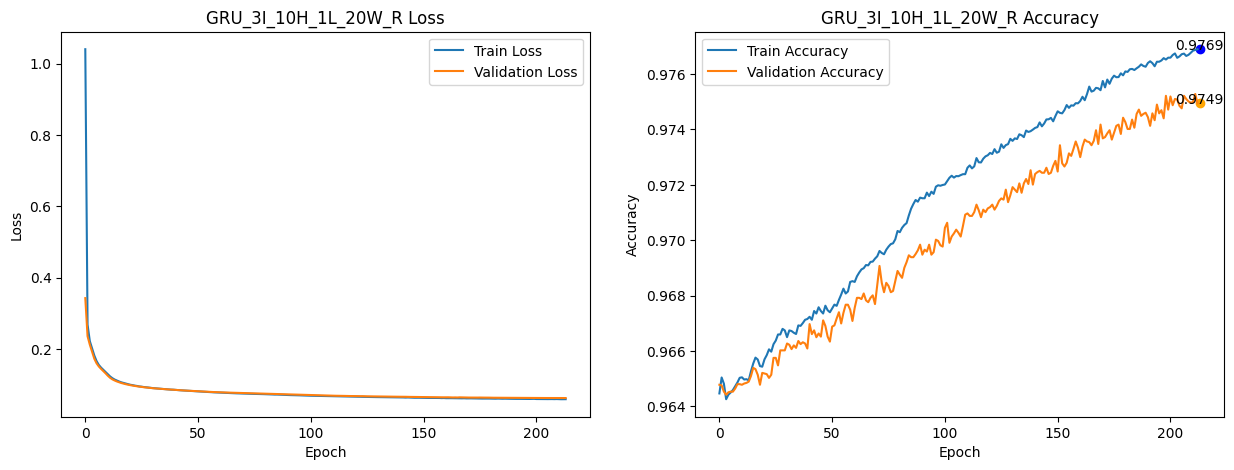

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.title(f"GRU_{INPUT_SIZE}I_{HIDDEN_SIZE}H_{NUM_LAYERS}L_{WINDOW_SIZE}W_{ACCELERATION_DATA_TYPE[0]} Loss")
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.title(f"GRU_{INPUT_SIZE}I_{HIDDEN_SIZE}H_{NUM_LAYERS}L_{WINDOW_SIZE}W_{ACCELERATION_DATA_TYPE[0]} Accuracy")
plt.plot(train_accuracy[1:], label='Train Accuracy')
plt.plot(val_accuracy[1:], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 마지막 Accuracy 점 찍기 및 텍스트 표시
last_epoch = len(train_accuracy) - 1

# Train accuracy
plt.scatter(last_epoch, train_accuracy[-1], color='blue')
plt.text(last_epoch, train_accuracy[-1],
         f"{train_accuracy[-1]:.4f}",
         color='black', ha='center')


# Validation accuracy
plt.scatter(last_epoch, val_accuracy[-1], color='orange')
plt.text(last_epoch, val_accuracy[-1],
         f"{val_accuracy[-1]:.4f}",
         color='black', ha='center')

# 저장 및 출력
plt.savefig(f"GRU_{INPUT_SIZE}I_{HIDDEN_SIZE}H_{NUM_LAYERS}L_{WINDOW_SIZE}W_{ACCELERATION_DATA_TYPE[0]}_GRAPH")
plt.show()


In [ ]:
model(data.to(device, dtype = torch.float32)[0][0].unsqueeze(0).unsqueeze(1))

(tensor([[[  3.6340,   2.0144,  -1.3397,  -6.0001, -15.1176]]],
        grad_fn=<ViewBackward0>),
 tensor([[[ 0.2951, -0.8346,  0.4210, -0.9752, -0.1669, -0.8482,  0.8390,
           -0.1772,  0.8784,  0.9154]]], grad_fn=<StackBackward0>))

# 6. Downloading Model

In [ ]:
# result = torch.jit.trace(model, data.permute(1, 0, 2).to(device, dtype = torch.float32))

# result.save(f"GRU_{INPUT_SIZE}I_{HIDDEN_SIZE}H_{NUM_LAYERS}L_{WINDOW_SIZE}W.pt")

In [ ]:
!pip install onnx

In [ ]:
import torch.onnx

torch.onnx.export(
    model,
    data.permute(1, 0, 2).to(device, dtype=torch.float32),
    f"GRU_{INPUT_SIZE}I_{HIDDEN_SIZE}H_{NUM_LAYERS}L_{WINDOW_SIZE}W_{ACCELERATION_DATA_TYPE[0]}.onnx",
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'seq_len', 1: 'batch_size'},
    },
    opset_version=12
)

/usr/local/lib/python3.11/dist-packages/torch/onnx/symbolic_opset9.py:4277: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
